In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
import numpy as np
from datetime import datetime

df = pd.read_excel("bd/bd_165_cfi.xlsx")
df1 = pd.read_excel("informes/informe CFI.xlsx")
excel = "reporte_cfi.xlsx"
excel2 = "reporte_m_cfi.xlsm"
correo = "enrique.paredes05@gmail.com; eparedes.quimarc@outlook.com"
asunto = "GESTIÓN DEL CICLO DE FORMACIÓN INTERNA Y COMUNIDADES PROFESIONALES DE APRENDIZAJE - " + datetime.now().strftime("%m/%d/%Y")

#histograma
entrada = "M1_ENTRADA"
salida = "M1_SALIDA"
col1 = [entrada, salida]

for column in df.columns:
    df[column] = df[column].fillna(0)

col_notas = ['M1_SALIDA', 'M2_SALIDA']
len(col_notas)

df["avance_curso"]=(np.where(df['M1_SALIDA'] == 0, 0,1)+np.where(df['M2_SALIDA'] == 0, 0,1))/len(col_notas)

In [2]:
#retirados
df["retirados"]=np.where((df['dni'] == 45963671) + (df['dni'] == 33591651) + (df['dni'] == 40698185), 1,0)

In [3]:
#nota final
df['promedio_final'] = df[col_notas].sum(axis=1)/len(col_notas)
df["promedio_final_condicion"] = np.where(df["promedio_final"] >= 13.5 , "aprobado", "desaprobado")
df["publico_objetivo"]=1

df1= df1.rename(columns={'Último acceso al curso':'fecha'})
df1= df1.rename(columns={'Código oficial':'dni'})
df1= df1.rename(columns={'Tiempo en el curso':'tiempo'})

df = pd.merge(df,df1[['fecha', 'dni']])
df['fecha_ultimo_ingreso_plataforma']=df["fecha"]
df=df.drop(['fecha'], axis=1)
hoy = pd.datetime.now()
df["dias_ausencia"] = (hoy - df["fecha_ultimo_ingreso_plataforma"]).dt.days


df = pd.merge(df,df1[['tiempo', 'dni']])
df["ingreso_curso"] = np.where(df["tiempo"] == "00:00:00" , "NO", "SI")
df=df.drop(['tiempo'], axis=1)

df["tipo_documento"]=df["tipo_documento"].astype(int)
df["tipo_documento"]=np.where(df['tipo_documento'] == 1, "DNI","OTROS")

df["estado_participante"] = np.where(df["avance_curso"] > 0 , "Activo", "No Activo")

df["situacion_final"] = np.where((df["promedio_final_condicion"] == "aprobado") & (df["avance_curso"] == 1) & (df["compromiso"] == 20) , "Certificado", np.where((df["promedio_final_condicion"] == "desaprobado") & (df["compromiso"] == 20),"Desaprobado","Abandono"))
df["activos_curso"] = np.where(df["estado_participante"] =="Activo" , 1, 0)
df["aprobados_certificados"] = np.where(df["situacion_final"] =="Certificado" , 1, 0)
df["desaprobados"] = np.where(df["situacion_final"] =="Desaprobado" , 1, 0)
df["abandonos"] = np.where(df["situacion_final"] =="Abandono" , 1, 0)


C:\Users\difoca05\AppData\Local\Temp\ipykernel_19004\2467836343.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  hoy = pd.datetime.now()


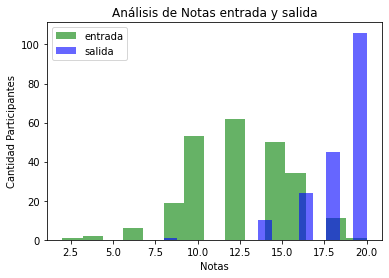

In [4]:

m_entrada = df[entrada][df[entrada]!=0]
m_salida = df[salida][df[salida]!=0]
plt.hist(m_entrada, bins=15, color="g",alpha = 0.6, label='entrada')
plt.hist(m_salida, bins=15, color="b",alpha = 0.6, label='salida')
plt.title('Análisis de Notas entrada y salida')
plt.xlabel('Notas')
plt.ylabel('Cantidad Participantes')
plt.legend(loc='upper left')
plt.savefig('histograma.png')
plt.show()

In [5]:
df1 = df['region'].unique()
df2=df["region"].value_counts()


df3 = df[df.tipo_iged=='UGEL'].groupby(by='region', as_index=False).agg({'iged': pd.Series.nunique})
df3= df3.rename(columns={'iged':'UGEL'})
#df3=df[df.tipo_iged=='UGEL'].groupby('region').iged.nunique()
df4 = df[df.tipo_iged=='DRE / GRE'].groupby(by='region', as_index=False).agg({'iged': pd.Series.nunique})
df4= df4.rename(columns={'iged':'DRE/GRE'})

df5 = pd.merge(df4,df3, how = 'outer')
for column in df5.columns:
    df5[column] = df5[column].fillna(0)
    


In [6]:
df10 = df.groupby(['region'])['dni'].count()

# df11 = df.query('compromiso == 20')
# col11 = ['region', 'compromiso']
# df12 = df11[col11]
# df13 = df12.groupby(['region'])['compromiso'].count()

# df14 = pd.merge(df10, df13, how='outer')
df10


region
AMAZONAS              11
ANCASH                20
APURIMAC              14
AREQUIPA               4
AYACUCHO              13
CAJAMARCA             19
CALLAO                 4
CUSCO                  8
HUANCAVELICA           6
HUÁNUCO               10
ICA                   11
JUNÍN                 23
LA LIBERTAD           17
LAMBAYEQUE             8
LIMA METROPOLITANA    21
LIMA PROVINCIA        10
LORETO                 9
MADRE DE DIOS          4
MOQUEGUA               7
PASCO                  4
PIURA                 19
PUNO                  13
SAN MARTIN            11
TACNA                  4
TUMBES                 8
UCAYALI                6
Name: dni, dtype: int64

In [7]:
df7 = df[col1][(df[entrada] !=0) & (df[salida] !=0)].describe()
df7

,M1_ENTRADA,M1_SALIDA
count,174.000000,174.000000
mean,12.528736,18.666667
std,2.761582,1.927391
min,4.000000,8.000000
25%,10.000000,18.000000
50%,12.000000,20.000000
75%,14.000000,20.000000
max,20.000000,20.000000


In [8]:
with pd.ExcelWriter(excel2, mode="a",engine="openpyxl",if_sheet_exists="overlay", engine_kwargs={"keep_vba": True}) as writer:
    df.to_excel(writer, sheet_name='base_datos' ,index=False)
    df7.to_excel(writer,sheet_name="estadistica", startrow=2 , startcol= 7, index=False, header=True)
    df5.to_excel(writer,sheet_name="estadistica", startrow=2 , startcol= 0, index=False, header=True)
    
#
    
wb = openpyxl.load_workbook(excel2, read_only=False, keep_vba=True)
ws=wb["estadistica"]
img = openpyxl.drawing.image.Image('histograma.png')
ws.add_image(img,"H13")

ws['H1'] = "COMPARATIVO COMPRUEBA ENTRADA Y SALIDA"
ws['A1'] = "IGED PARTICIPANTES"
ws['E4'] = "TOTAL DRE/GRE"
ws['E5'] = "TOTAL UGEL"
ws['F4'] = df4['DRE/GRE'].sum()
ws['F5'] = df3['UGEL'].sum()

wb.save(excel2)    

In [ ]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders

username = "difoca05@minedu.gob.pe"
password = "Minedu2022+"
mail_from = "difoca05@minedu.gob.pe"
mail_to = correo
mail_subject = asunto
mail_body = "Buen día, adjunto reporte a la fecha " + datetime.now().strftime("%m/%d/%Y") + ". Saludos, Enrique Paredes"
mail_attachment= excel

# mail_attachment_name= mail_attachment

# mimemsg = MIMEMultipart()
# mimemsg['From']=mail_from
# mimemsg['To']=mail_to
# mimemsg['Subject']=mail_subject
# mimemsg.attach(MIMEText(mail_body, 'plain'))

# with open(mail_attachment, "rb") as attachment:
#     mimefile = MIMEBase('application', 'octet-stream')
#     mimefile.set_payload((attachment).read())
#     encoders.encode_base64(mimefile)
#     mimefile.add_header('Content-Disposition', "attachment; filename= %s" % mail_attachment_name)
#     mimemsg.attach(mimefile)
#     connection = smtplib.SMTP(host='smtp.office365.com', port=587)
#     connection.starttls()
#     connection.login(username,password)
#     connection.send_message(mimemsg)
#     connection.quit()